# Text Clustering & EDA on COVID-19 Tweet

## About Dataset
Coronavirus tweets NLP Dataset contains 6 columns, each are:

1- UserName: Name

2- ScreenName: Screen Name

3- Location: Tweeted from

4- TweetAt: Tweeted At

5- OriginalTweet: Twitter Text

6- Sentiment: Label

## Notebook Objectives

- EDA on each columns

- Tweets Analysis (contains 3 parts: unigram, hashtags & mentions, each sentiments)

- Text Clustering using kmeans and PCA

### Import necessary libraries

In [1]:
# For Data
import pandas as pd
import numpy as np

#  For Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import missingno as msno
from wordcloud import WordCloud

# For NLP
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


# For Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

# For Styling
plt.style.use('default')

In [2]:
df = pd.read_csv('Corona_NLP_train.csv',encoding='latin-1')
df['TweetAt'] = pd.to_datetime(df['TweetAt'])
df['Length'] = df['OriginalTweet'].apply(len)
df.head()

C:\Users\User\AppData\Local\Temp\ipykernel_21916\4195825520.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['TweetAt'] = pd.to_datetime(df['TweetAt'])


UserName  ScreenName   Location    TweetAt  \
0      3799       48751     London 2020-03-16   
1      3800       48752         UK 2020-03-16   
2      3801       48753  Vagabonds 2020-03-16   
3      3802       48754        NaN 2020-03-16   
4      3803       48755        NaN 2020-03-16   

                                       OriginalTweet           Sentiment  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral   
1  advice Talk to your neighbours family to excha...            Positive   
2  Coronavirus Australia: Woolworths to give elde...            Positive   
3  My food stock is not the only one which is emp...            Positive   
4  Me, ready to go at supermarket during the #COV...  Extremely Negative   

   Length  
0     111  
1     237  
2     131  
3     306  
4     310

###   Exploring columns 

In [3]:
location = df['Location'].value_counts()[:20]

In [4]:
print(location)

Location
London                     540
United States              528
London, England            520
New York, NY               395
Washington, DC             373
United Kingdom             337
Los Angeles, CA            281
India                      268
UK                         232
Australia                  225
USA                        223
Canada                     191
England, United Kingdom    191
Toronto, Ontario           160
Global                     159
Chicago, IL                155
California, USA            153
San Francisco, CA          152
Boston, MA                 150
New York, USA              140
Name: count, dtype: int64


In [5]:
location = df['Location'].value_counts()[:10]
fig = px.bar(x=location.index,y=location.values,text=location.values,
       color = location.index, color_discrete_sequence=px.colors.sequential.deep,
        title = 'Distribution of Top 10 Locations',
        template = 'simple_white')

fig.update_traces(textposition='inside',
                  textfont_size=11)

fig.update_layout(
    xaxis_title = 'Locations',
    yaxis_title = 'Count of Tweets',
    font=dict(size=17,family="Times New Roman"),)

fig.show()

In [6]:
sentiment = df["Sentiment"].value_counts()
fig = px.pie(values=sentiment.values, 
             names=sentiment.index,
             color_discrete_sequence=px.colors.sequential.Greens)
fig.update_traces(textposition='inside',
                  textfont_size=11,
                  textinfo='percent+label')
fig.update_layout(title_text="Category Pie Graph",
                  uniformtext_minsize=12, 
                  uniformtext_mode='hide')

fig.show()

In [7]:
positive = df.loc[np.where(df['Sentiment'] == 'Positive')].reset_index()
negative = df.loc[np.where(df['Sentiment'] == 'Negative')].reset_index()
neutral = df.loc[np.where(df['Sentiment'] == 'Neutral')].reset_index()
extremely_positive = df.loc[np.where(df['Sentiment'] == 'Extremely Positive')].reset_index()
extremely_negative = df.loc[np.where(df['Sentiment'] == 'Extremely Negative')].reset_index()

In [8]:
hist_data = [extremely_positive['Length'],positive['Length'],neutral['Length'],
             negative['Length'],extremely_negative['Length']]

group_labels = ['extremely_positive','positive','neutral','negative','extremely_negative']

colors = ['navy', 'blue', 'lightblue','lightsalmon','red']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, show_hist=False , colors = colors)

# Add title
fig.update_layout(title_text='Length distribution each sentiments', template = 'simple_white')
fig.show()

### Text Analysis

In [9]:
def get_all_str(tweet):
    sentence = ''
    for words in tweet:
        sentence += words
    sentence = sentence.lower()
    return sentence

def get_str(lst):
    sentence = ''
    for char in lst:
        sentence += char+' '
    sentence = sentence.lower()
    return sentence

def get_word(text): 
    result = nltk.RegexpTokenizer(r'\w+').tokenize(text.lower())
    return result

def get_hashtag(text):
    result = nltk.RegexpTokenizer(r'(?<=#)\w+').tokenize(text.lower())
    return result

def get_mention(text):
    result = nltk.RegexpTokenizer(r'(?<=@)\w+').tokenize(text.lower())
    return result 

def stopword_list(stop):
    lst = stopwords.words('english')
    for stopword in stop:
        lst.append(stopword)
    return lst

def remove_stopword(stopwords, lst):    
    stoplist = stopword_list(stopwords)
    txt = ''
    for idx in range(len(lst)):
        txt += lst[idx]
        txt += '\n'
    cleanwordlist = [word for word in txt.split() if word not in stoplist] 
#     print(stoplist)
    return cleanwordlist

def pos_remove_noun(tagged):
    remove_noun = [word for word,pos in tagged if pos not in ['NN','NNS','NNP','NNPS']]
    txt = ''
    for i in range(len(remove_noun)):
        txt += remove_noun[i]
        txt += '\n'
    return cleanwordlist

def lemmatization(words):
    lemm = WordNetLemmatizer()
    tokens = [lemm.lemmatize(word) for word in words]
#     txt= ' '.join(tokens)
    return tokens

def Freq_df(cleanwordlist):
    Freq_dist_nltk = nltk.FreqDist(cleanwordlist)
    df_freq = pd.DataFrame.from_dict(Freq_dist_nltk, orient='index')
    df_freq.columns = ['Frequency']
    df_freq.index.name = 'Term'
    df_freq = df_freq.sort_values(by=['Frequency'],ascending=False)
    df_freq = df_freq.reset_index()
    return df_freq

# function to plot word cloud of words
def Word_Cloud(data, color_background, colormap, title):
    plt.figure(figsize = (20,15))
    wc = WordCloud(width=800, 
               height=400, 
               max_words=50,
               colormap= colormap,
               max_font_size=140,
               random_state=8888, 
               background_color=color_background).generate_from_frequencies(data)
    
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

In [10]:
def whole_string(sent):
    all_str = get_all_str(sent)
    words = get_word(all_str)
    removed = remove_stopword(['http','https','co'],words)
    freq_df = Freq_df(removed)
    return freq_df

In [11]:
freq_df = whole_string(df['OriginalTweet'])
top_10 = freq_df[:10]

fig = px.bar(top_10, x = 'Term', y = 'Frequency',text = 'Frequency', color='Term',
             color_discrete_sequence=px.colors.sequential.PuBuGn, title = 'Rank of terms',
             template = 'simple_white')
    
fig.update_traces(textposition='inside',
                  textfont_size=11)
fig.show()

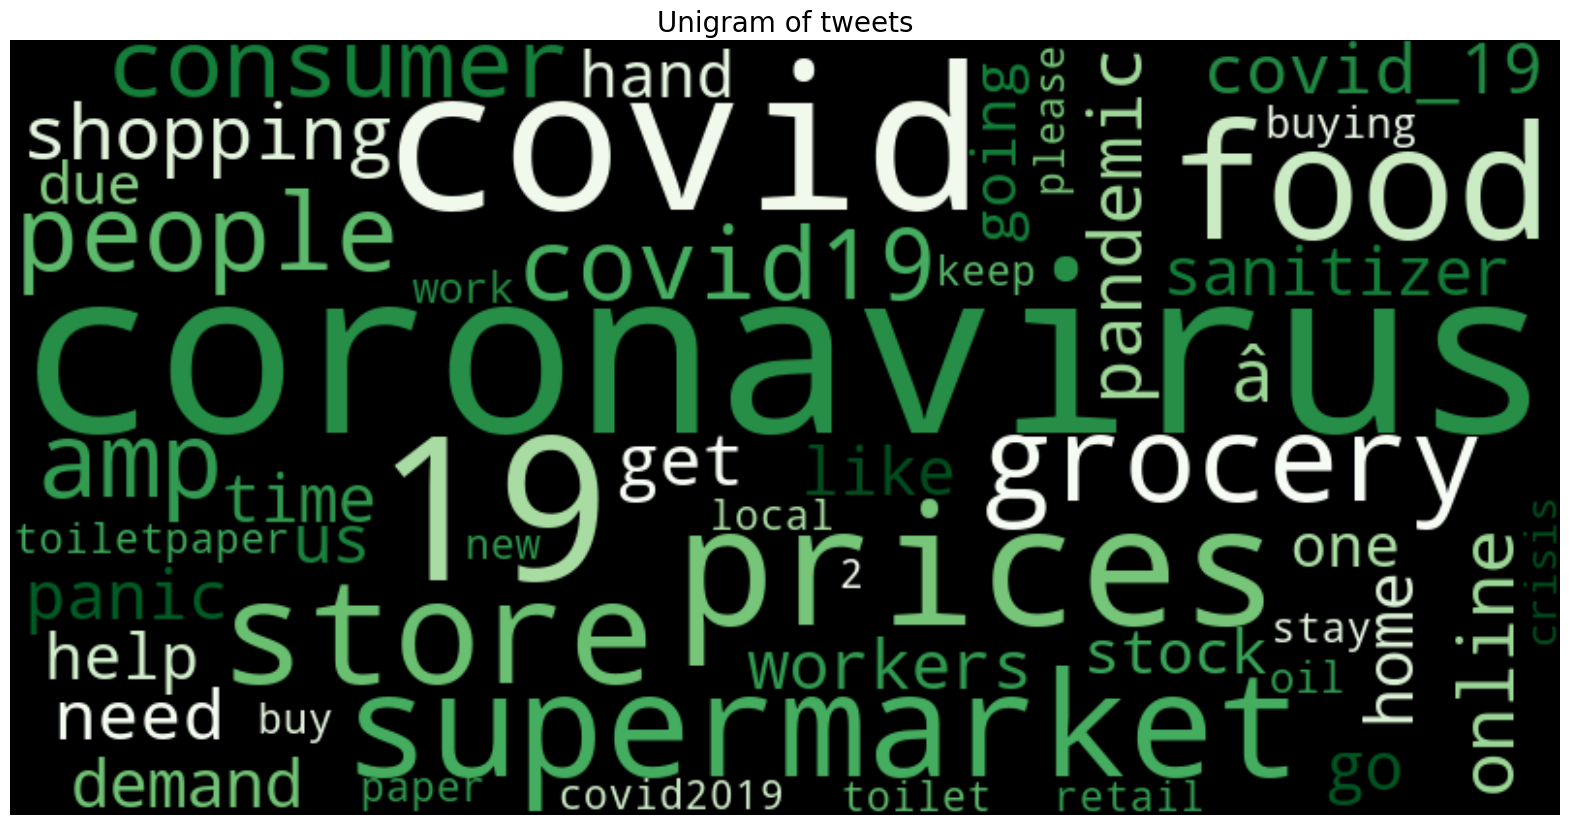

In [12]:
data = freq_df.set_index('Term').to_dict()['Frequency']

Word_Cloud(data ,'black', 'Greens_r', 'Unigram of tweets')

In [13]:
def hashtag(sent):
    all_str = get_all_str(sent)
    words = get_hashtag(all_str)
    removed = remove_stopword(['http','https','co'],words)
    freq_df = Freq_df(removed)
    return freq_df

def mention(sent):
    all_str = get_all_str(sent)
    words = get_mention(all_str)
    removed = remove_stopword(['http','https','co'],words)
    freq_df = Freq_df(removed)
    return freq_df
hashtag_df = hashtag(df['OriginalTweet'])
mention_df = mention(df['OriginalTweet'])

In [14]:
def Word_Cloud(data, color_background, colormap, title):
    plt.figure(figsize = (10,15))
    wc = WordCloud(width=800, 
               height=400, 
               max_words=50,
               colormap= colormap,
               max_font_size=140,
               random_state=8888, 
               background_color=color_background).generate_from_frequencies(data)
    
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

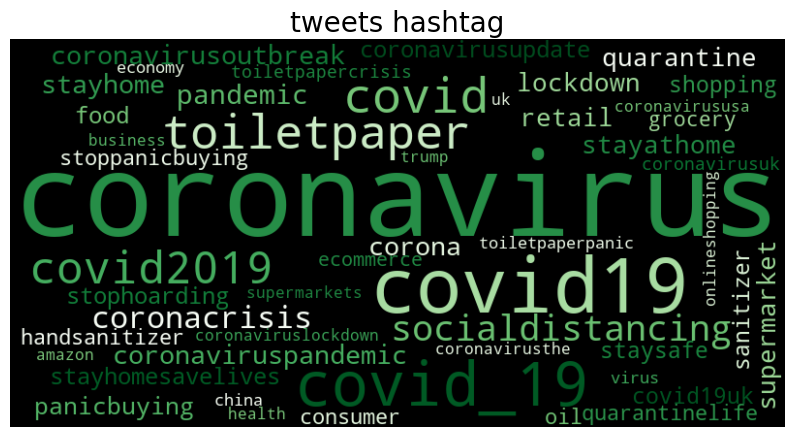

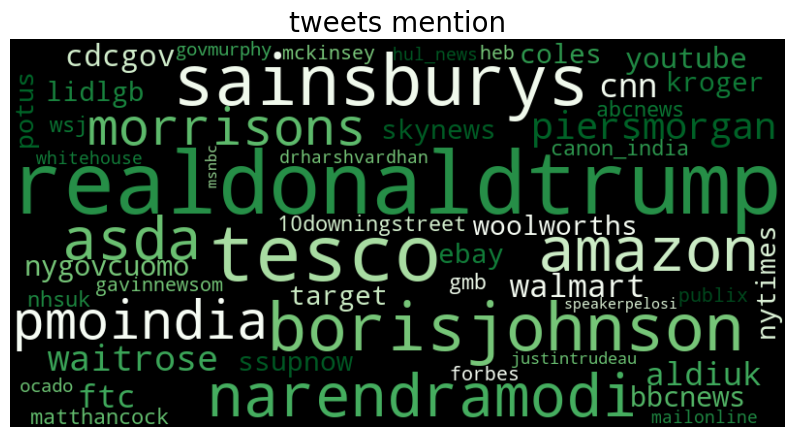

In [15]:
hashtag = hashtag_df.set_index('Term').to_dict()['Frequency']
mention = mention_df.set_index('Term').to_dict()['Frequency']
Word_Cloud(hashtag ,'black', 'Greens_r', 'tweets hashtag')
Word_Cloud(mention ,'black', 'Greens_r', 'tweets mention')

In [16]:
df.head()

UserName  ScreenName   Location    TweetAt  \
0      3799       48751     London 2020-03-16   
1      3800       48752         UK 2020-03-16   
2      3801       48753  Vagabonds 2020-03-16   
3      3802       48754        NaN 2020-03-16   
4      3803       48755        NaN 2020-03-16   

                                       OriginalTweet           Sentiment  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral   
1  advice Talk to your neighbours family to excha...            Positive   
2  Coronavirus Australia: Woolworths to give elde...            Positive   
3  My food stock is not the only one which is emp...            Positive   
4  Me, ready to go at supermarket during the #COV...  Extremely Negative   

   Length  
0     111  
1     237  
2     131  
3     306  
4     310

In [20]:
positive_df = whole_string(positive['OriginalTweet'])
negative_df = whole_string(negative['OriginalTweet'])
neutral_df = whole_string(neutral['OriginalTweet'])
extremely_positive_df = whole_string(extremely_positive['OriginalTweet'])
extremely_negative_df = whole_string(extremely_negative['OriginalTweet'])

In [21]:
# data = dict(zip(positive_df['Term'].tolist(), positive_df['Frequency'].tolist()))
expost = extremely_positive_df.set_index('Term').to_dict()['Frequency']
post= positive_df.set_index('Term').to_dict()['Frequency']
neut = neutral_df.set_index('Term').to_dict()['Frequency']
nega = negative_df.set_index('Term').to_dict()['Frequency']
exnega = extremely_negative_df.set_index('Term').to_dict()['Frequency']

In [22]:
# function to plot word cloud of words
def Word_Cloud(data, color_background, colormap, title):
    plt.figure(figsize = (15,6))
    wc = WordCloud(width=800, 
               height=400, 
               max_words=50,
               colormap= colormap,
               max_font_size=140,
#                min_font_size = 2,
               random_state=8888, 
               background_color=color_background,).generate_from_frequencies(data)
    plt.imshow(wc, interpolation='bilinear')

    plt.title(title, fontsize=20)
    plt.axis('off')
#     plt.show()

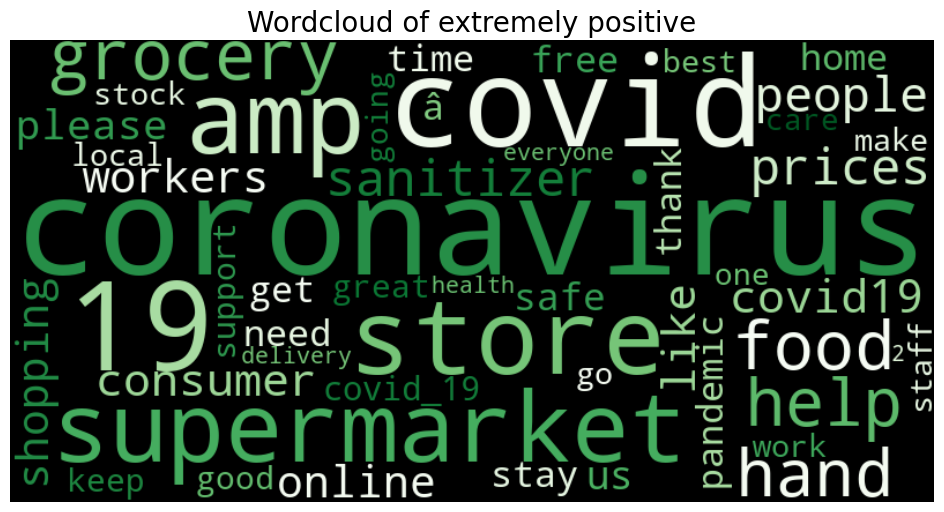

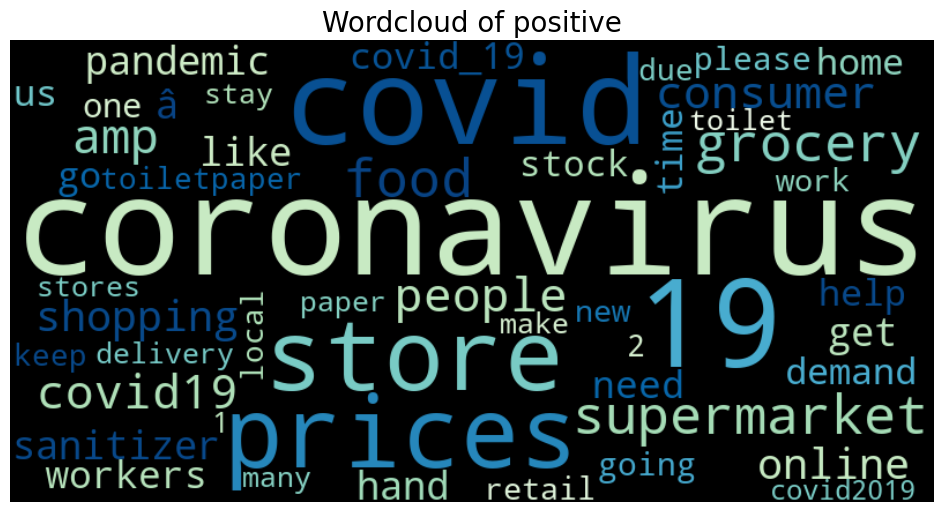

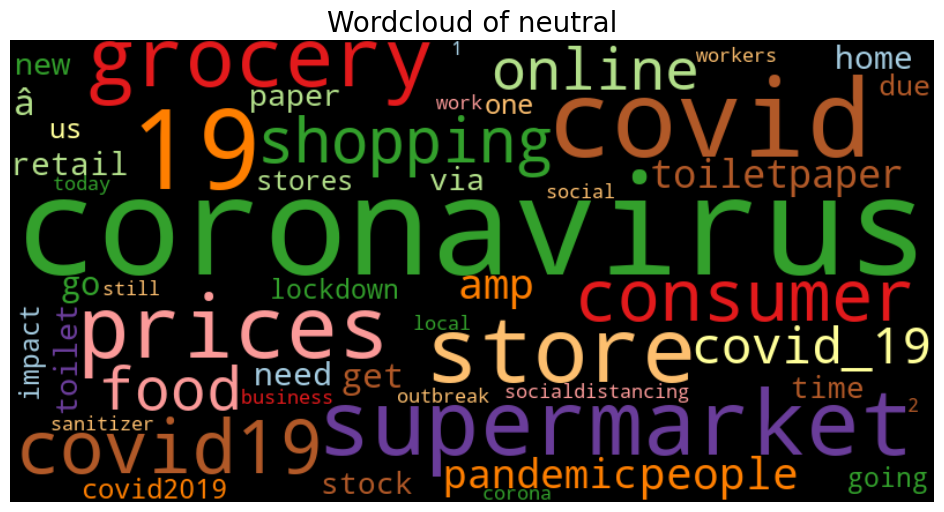

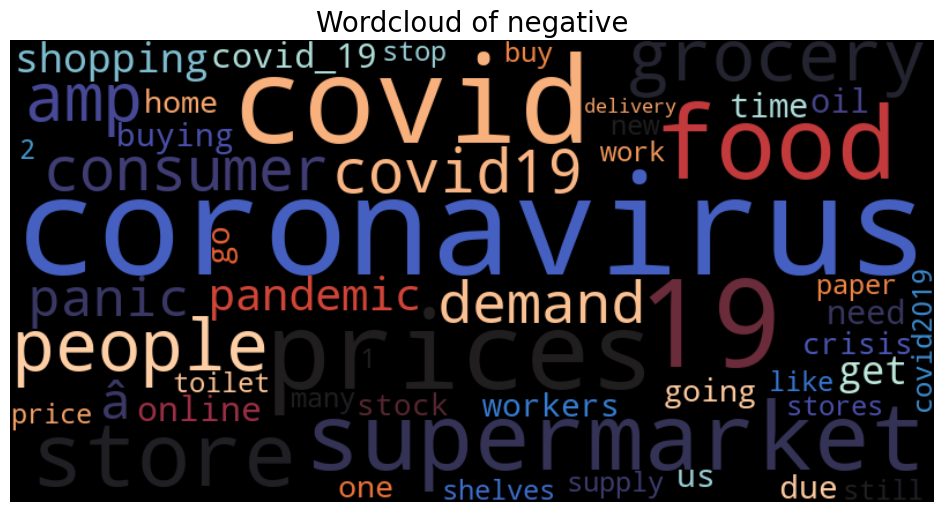

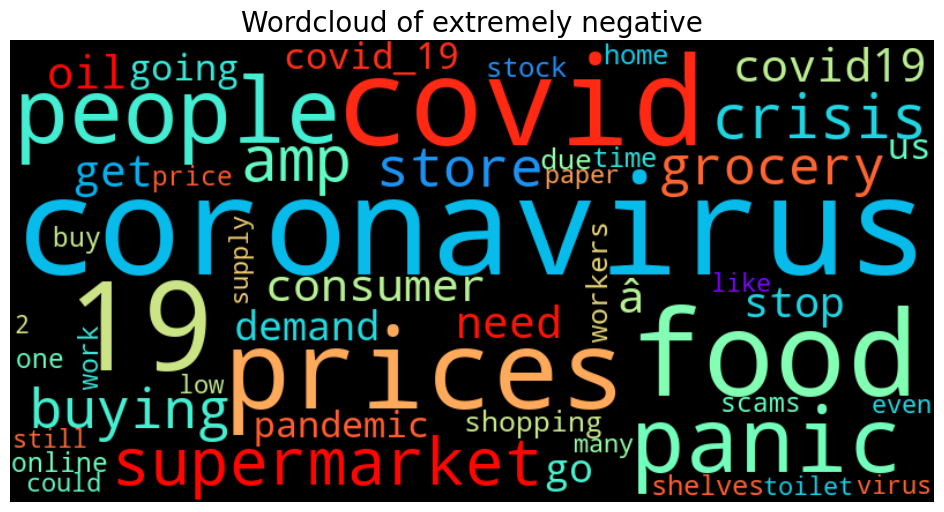

In [23]:
Word_Cloud(expost ,'black', 'Greens_r', 'Wordcloud of extremely positive')
Word_Cloud(post ,'black', 'GnBu', 'Wordcloud of positive')
Word_Cloud(neut ,'black', 'Paired', 'Wordcloud of neutral')
Word_Cloud(nega ,'black', 'icefire', 'Wordcloud of negative')
Word_Cloud(exnega ,'black', 'rainbow', 'Wordcloud of extremely negative')

## Text Preprocessing

In this section, well convert text data into machine-readable vector used for text clustering section.

3 main parts in the section:

- Text cleaning (remove & lemmatize text data)

- CountVectorizer

- TfidfTransformer

### Text Cleaning

In [24]:
df = df[:15000]
def preprocessing(text):
    words = get_word(text)
    lemma = lemmatization(words)
    removed = remove_stopword(['http','ly'],lemma)
    return removed
df['OriginalTweet'] = df['OriginalTweet'].apply(preprocessing)
df['OriginalTweet'] = df['OriginalTweet'].apply(get_str)

## CountVectorizer

In [25]:
vector = CountVectorizer()
X = vector.fit(df['OriginalTweet'])
X_transform = X.transform(df['OriginalTweet'])

In [26]:
print(X_transform.shape)
pd.DataFrame(X_transform.toarray(), columns=vector.get_feature_names_out()).head(5)

(15000, 33877)


00  000  0000009375  0000hrs  000francs  000s  008  00am  00hrs  \
0   0    0           0        0          0     0    0     0      0   
1   0    0           0        0          0     0    0     0      0   
2   0    0           0        0          0     0    0     0      0   
3   0    0           0        0          0     0    0     0      0   
4   0    0           0        0          0     0    0     0      0   

   00pdsup4wb  ...  zyocje8e18  zyrmiro9cq  zyxg2qqvkx  zz7gjzlvns  \
0           0  ...           0           0           0           0   
1           0  ...           0           0           0           0   
2           0  ...           0           0           0           0   
3           0  ...           0           0           0           0   
4           0  ...           0           0           0           0   

   zzczwfp7ih  zzkxpxsnuh  zzsmn5qjla  zzz  zã  zã¼rich  
0           0           0           0    0   0        0  
1           0           0           0    0   0        0  
2           0           0           0    0   0        0  
3           0           0           0    0   0        0  
4           0           0           0    0   0        0  

[5 rows x 33877 columns]

## TfidfTransformer

In [27]:
Tfidf = TfidfTransformer()
tfidf_transformer = Tfidf.fit(X_transform)
X = tfidf_transformer.transform(X_transform)

In [28]:
print(X.shape)
df_tfidf = pd.DataFrame(X.toarray(), columns=vector.get_feature_names_out())
df_tfidf.head(5)

(15000, 33877)


00  000  0000009375  0000hrs  000francs  000s  008  00am  00hrs  \
0  0.0  0.0         0.0      0.0        0.0   0.0  0.0   0.0    0.0   
1  0.0  0.0         0.0      0.0        0.0   0.0  0.0   0.0    0.0   
2  0.0  0.0         0.0      0.0        0.0   0.0  0.0   0.0    0.0   
3  0.0  0.0         0.0      0.0        0.0   0.0  0.0   0.0    0.0   
4  0.0  0.0         0.0      0.0        0.0   0.0  0.0   0.0    0.0   

   00pdsup4wb  ...  zyocje8e18  zyrmiro9cq  zyxg2qqvkx  zz7gjzlvns  \
0         0.0  ...         0.0         0.0         0.0         0.0   
1         0.0  ...         0.0         0.0         0.0         0.0   
2         0.0  ...         0.0         0.0         0.0         0.0   
3         0.0  ...         0.0         0.0         0.0         0.0   
4         0.0  ...         0.0         0.0         0.0         0.0   

   zzczwfp7ih  zzkxpxsnuh  zzsmn5qjla  zzz   zã  zã¼rich  
0         0.0         0.0         0.0  0.0  0.0      0.0  
1         0.0         0.0         0.0  0.0  0.0      0.0  
2         0.0         0.0         0.0  0.0  0.0      0.0  
3         0.0         0.0         0.0  0.0  0.0      0.0  
4         0.0         0.0         0.0  0.0  0.0      0.0  

[5 rows x 33877 columns]

## Text Clustering

We'll cluster converted data in this section, using Kmeans clustering. Mainly three parts in the section, each are:


C:\Users\User\AppData\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



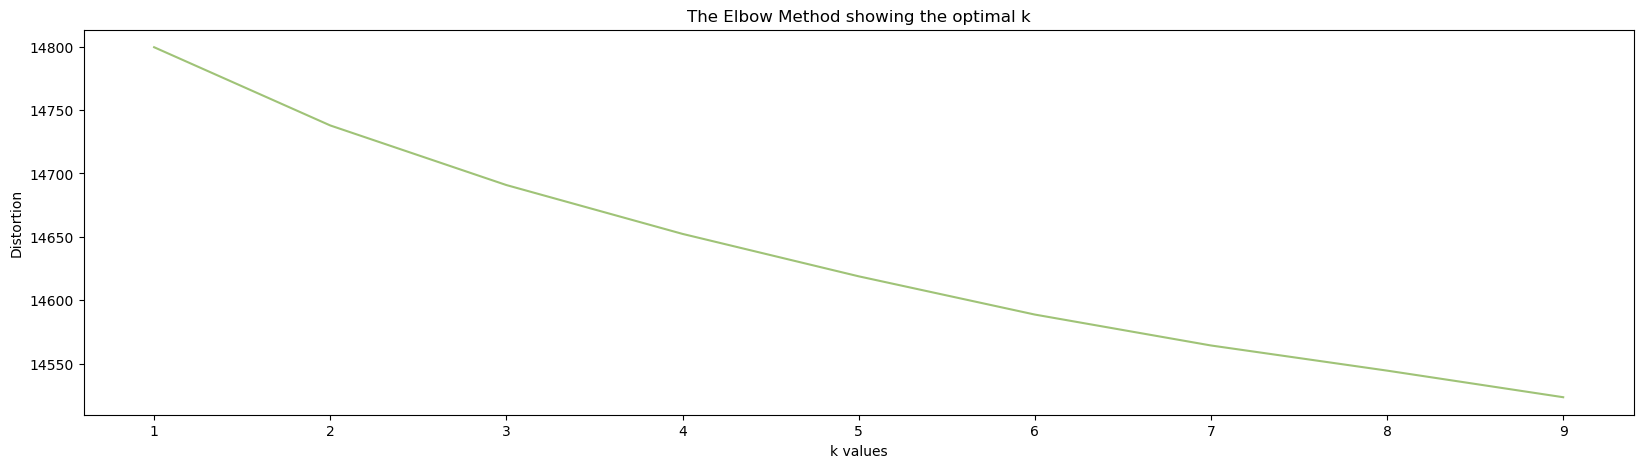

In [29]:
distortions = []
K = range(1,10)
for k in K:
    kmean = KMeans(n_clusters=k,random_state=7)
    kmean.fit(X)
    distortions.append(kmean.inertia_)
    
plt.figure(figsize=(20,5))
plt.plot(K, distortions, '-',color='g')
plt.xlabel('k values')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
PCA = pca.fit(X.toarray())
X_pca = pca.transform(X.toarray())

C:\Users\User\AppData\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\User\AppData\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\User\AppData\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\User\AppData\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\User\AppData\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1412: Future

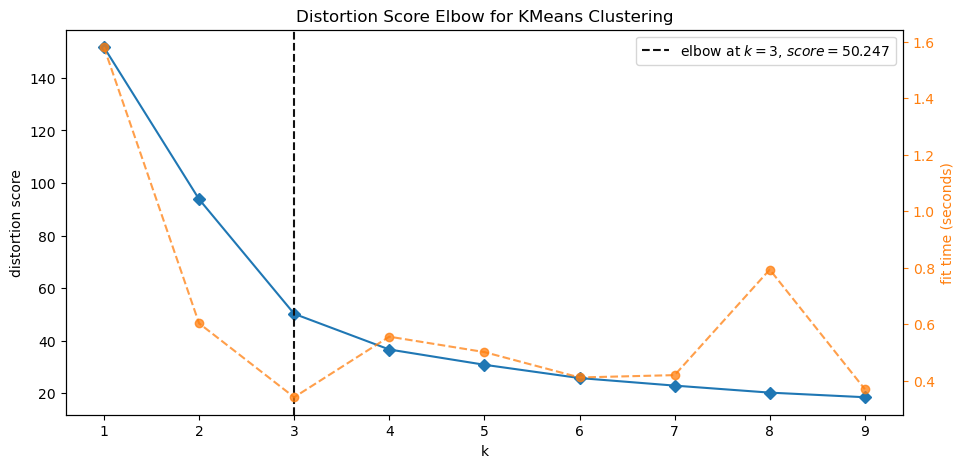

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(1,10),size=(1080, 500))

visualizer.fit(X_pca)        
visualizer.show() 

In [32]:
silhouette = []
K = range(2,10)

for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_pca)
    preds = kmeanModel.predict(X_pca)
    silhouette.append(silhouette_score(X_pca, preds))
    
plt.figure(figsize=(20,5))
plt.plot(K, silhouette, '-',color='g')
plt.xlabel('k values')
plt.ylabel('Silhouette score')
plt.title('Silho

SyntaxError: EOL while scanning string literal (899008032.py, line 14)